# ETF Risk–Return & Diversification — Auto Downloader
This notebook downloads daily Adj Close data for a set of ETFs, computes metrics, exports CSVs and saves charts (PNG). Edit the `tickers`, `start`, and `risk_free` below.

C:\Users\ishac\AppData\Local\Temp\ipykernel_23252\2946188228.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, start=start, end=end, progress=False, group_by="ticker")


✅ Downloaded data successfully:
                   SPY         QQQ         XLV        XLE        VNQ  \
Date                                                                   
2022-01-03  453.210419  392.184052  131.198914  50.003017  99.251991   
2022-01-04  453.058624  387.097198  129.467651  51.733288  99.131256   
2022-01-05  444.358917  375.205231  128.545563  51.724545  96.294266   
2022-01-06  443.941467  374.941620  127.058968  52.878056  96.380486   
2022-01-07  442.186310  370.879913  126.409744  53.603374  95.742378   

                 ICLN  
Date                   
2022-01-03  20.298841  
2022-01-04  19.984941  
2022-01-05  19.052757  
2022-01-06  18.786415  
2022-01-07  18.700808  
Metrics:


,Annualized Return,Annualized Vol,Sharpe
XLE,16.09%,26.25%,61.30%
SPY,11.17%,18.26%,61.18%
QQQ,12.69%,23.94%,53.02%
XLV,2.86%,15.14%,18.92%
VNQ,-1.86%,20.09%,-9.26%
ICLN,-5.01%,27.39%,-18.31%


Correlation matrix:


,SPY,QQQ,XLV,XLE,VNQ,ICLN
SPY,1.00,0.96,0.69,0.46,0.70,0.57
QQQ,0.96,1.00,0.55,0.33,0.58,0.55
XLV,0.69,0.55,1.00,0.32,0.65,0.41
XLE,0.46,0.33,0.32,1.00,0.35,0.30
VNQ,0.70,0.58,0.65,0.35,1.00,0.59
ICLN,0.57,0.55,0.41,0.30,0.59,1.00


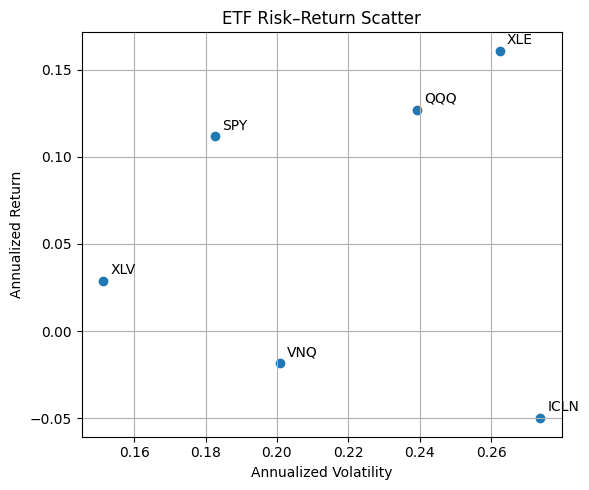

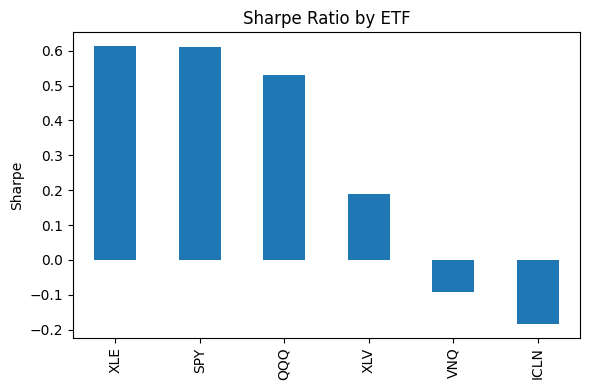

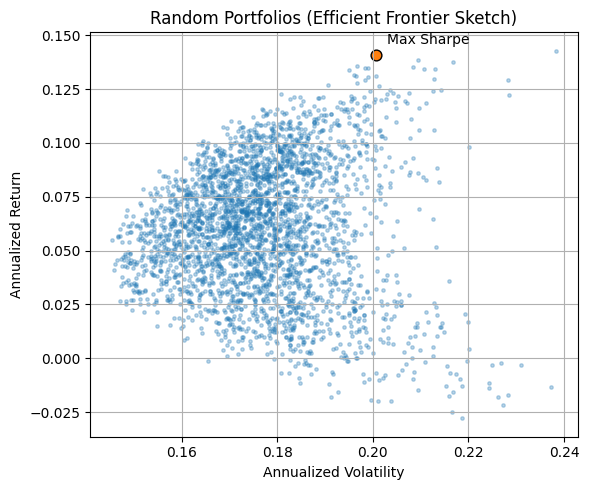

Saved files: metrics_etf.csv, correlations_etf.csv, prices_etf.csv, returns_etf.csv, risk_return_scatter.png, sharpe_by_etf.png, efficient_frontier.png


In [5]:

# --- Setup ---
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# ---- Settings ----
tickers = ["SPY","QQQ","XLV","XLE","VNQ","ICLN"]
start = "2022-01-01"
end = None  # up to today
risk_free = 0.00  # annualized rf (set to 0.02 for 2% if desired)

# --- Download prices ---
raw = yf.download(tickers, start=start, end=end, progress=False, group_by="ticker")

# Handle both single- and multi-level column structures robustly
if isinstance(raw.columns, pd.MultiIndex):
    # If columns are hierarchical (Ticker -> Field)
    close_cols = []
    for t in tickers:
        try:
            close_cols.append(raw[(t, "Adj Close")])
        except KeyError:
            close_cols.append(raw[(t, "Close")])  # fallback if Adj Close missing
    data = pd.concat(close_cols, axis=1)
    data.columns = tickers
else:
    # Flat columns (single ticker or simplified download)
    if "Adj Close" in raw.columns:
        data = raw[["Adj Close"]].rename(columns={"Adj Close": tickers[0]})
    elif "Close" in raw.columns:
        data = raw[["Close"]].rename(columns={"Close": tickers[0]})
    else:
        raise ValueError("No Adj Close or Close column found in Yahoo Finance data.")

# Clean up
data = data.dropna(how="all").ffill().dropna()
print("✅ Downloaded data successfully:")
print(data.head())


# --- Returns ---
rets = data.pct_change().dropna()

# --- Metrics ---
ann_factor = 252
ann_ret = (1 + rets).prod()**(ann_factor/len(rets)) - 1
ann_vol = rets.std() * np.sqrt(ann_factor)
sharpe = (ann_ret - risk_free) / ann_vol.replace(0, np.nan)

metrics = pd.DataFrame({
    "Annualized Return": ann_ret,
    "Annualized Vol": ann_vol,
    "Sharpe": sharpe
}).sort_values("Sharpe", ascending=False)

print("Metrics:")
display(metrics.style.format("{:.2%}"))

# --- Correlations ---
corr = rets.corr()
print("Correlation matrix:")
display(corr.style.format("{:.2f}"))

# --- Save CSVs ---
metrics.to_csv("metrics_etf.csv")
corr.to_csv("correlations_etf.csv")
data.to_csv("prices_etf.csv")
rets.to_csv("returns_etf.csv")

# --- Risk-Return scatter ---
plt.figure(figsize=(6,5))
plt.scatter(metrics["Annualized Vol"], metrics["Annualized Return"])
for t in metrics.index:
    x = metrics.loc[t, "Annualized Vol"]
    y = metrics.loc[t, "Annualized Return"]
    plt.annotate(t, (x, y), xytext=(5,5), textcoords="offset points")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("ETF Risk–Return Scatter")
plt.grid(True)
plt.tight_layout()
plt.savefig("risk_return_scatter.png", dpi=200)
plt.show()

# --- Sharpe bar chart ---
plt.figure(figsize=(6,4))
metrics["Sharpe"].plot(kind="bar")
plt.title("Sharpe Ratio by ETF")
plt.ylabel("Sharpe")
plt.tight_layout()
plt.savefig("sharpe_by_etf.png", dpi=200)
plt.show()

# --- Random portfolios (efficient frontier sketch) ---
n_port = 3000
weights = np.random.dirichlet(np.ones(len(tickers)), size=n_port)
port_rets = weights @ metrics["Annualized Return"].reindex(tickers).values
cov = rets.cov() * ann_factor
port_vols = np.sqrt(np.einsum('ij,jk,ik->i', weights, cov.values, weights))
port_sharpe = (port_rets - risk_free) / port_vols

plt.figure(figsize=(6,5))
plt.scatter(port_vols, port_rets, s=6, alpha=0.3)
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Random Portfolios (Efficient Frontier Sketch)")
i_star = np.nanargmax(port_sharpe)
plt.scatter(port_vols[i_star], port_rets[i_star], s=60, edgecolors="k")
plt.annotate("Max Sharpe", (port_vols[i_star], port_rets[i_star]), xytext=(8,8), textcoords="offset points")
plt.grid(True)
plt.tight_layout()
plt.savefig("efficient_frontier.png", dpi=200)
plt.show()

print("Saved files: metrics_etf.csv, correlations_etf.csv, prices_etf.csv, returns_etf.csv, "
      "risk_return_scatter.png, sharpe_by_etf.png, efficient_frontier.png")
